# HW 10 CLUSTERING BUSINESS

# cluster time trends in NYC businesses: 
# DATA
# Census Business data:
## download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
##  you can  download it with 4 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

In [253]:
import numpy as np
import os
import pandas as pd
import zipfile
import geopandas as gp
import sklearn.cluster
import pylab as pl
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
%pylab inline
from geopandas import GeoDataFrame

PUIDATA = os.getenv('PUIDATA')


Populating the interactive namespace from numpy and matplotlib


In [2]:
#!for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

#!for ((y=0; y<=1; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

#!for ((y=2; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

#!for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

In [3]:
path = os.getenv('PUIDATA')+'/'
#!mv *.zip "{path}"
#os.system('mv *.zip $PUIDATA')

In [4]:
#datetime.year('20' + set)

In [5]:
#Explore columns across files. 
for i in np.arange(0,15):
    if i < 10:
        set = '0' + str(i)
    else:
        set = str(i)
    fname = "zbp" + set + "totals.zip"
    zf = zipfile.ZipFile(path + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    print(df.columns)
for i in np.arange(94,100):
    if i < 10:
        set = '0' + str(i)
    else:
        set = str(i)
    fname = "zbp" + set + "totals.zip"
    zf = zipfile.ZipFile(path + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    print(df.columns)

Index([u'ZIP', u'NAME', u'EMPFLAG', u'EMP', u'QP1', u'AP', u'EST'], dtype='object')
Index([u'ZIP', u'NAME', u'EMPFLAG', u'EMP', u'QP1', u'AP', u'EST'], dtype='object')
Index([u'ZIP', u'NAME', u'EMPFLAG', u'EMP', u'QP1', u'AP', u'EST'], dtype='object')
Index([u'zip', u'name', u'empflag', u'emp', u'qp1', u'ap', u'est'], dtype='object')
Index([u'zip', u'name', u'empflag', u'emp', u'qp1', u'ap', u'est'], dtype='object')
Index([u'zip', u'name', u'empflag', u'emp', u'qp1', u'ap', u'est'], dtype='object')
Index([u'zip', u'name', u'empflag', u'emp', u'qp1', u'ap', u'est'], dtype='object')
Index([u'zip', u'name', u'empflag', u'emp_nf', u'emp', u'qp1_nf', u'qp1',
       u'ap_nf', u'ap', u'est'],
      dtype='object')
Index([u'zip', u'name', u'empflag', u'emp_nf', u'emp', u'qp1_nf', u'qp1',
       u'ap_nf', u'ap', u'est'],
      dtype='object')
Index([u'zip', u'name', u'empflag', u'emp_nf', u'emp', u'qp1_nf', u'qp1',
       u'ap_nf', u'ap', u'est'],
      dtype='object')
Index([u'zip', u'name', u

In [6]:
#Combine different files, clean up column names.
biz = pd.DataFrame()
for i in np.arange(0,15):
    if i < 10:
        set = '0' + str(i)
    else:
        set = str(i)
    fname = "zbp" + set + "totals.zip"
    zf = zipfile.ZipFile(path + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df.columns = map(str.lower, df.columns)
    df['year'] = int('20'+ set)
    biz = biz.append(df)
for i in np.arange(94,100):
    if i < 10:
        set = '0' + str(i)
    else:
        set = str(i)
    fname = "zbp" + set + "totals.zip"
    zf = zipfile.ZipFile(path + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df.columns = map(str.lower, df.columns)
    df['year'] = int('19'+ set)
    biz = biz.append(df)

In [7]:
biz['zip'] = pd.to_numeric(biz['zip'], errors = 'coerce')

In [8]:
biz.columns

Index([u'ap', u'ap_nf', u'city', u'cty_name', u'emp', u'emp_nf', u'empflag',
       u'est', u'name', u'qp1', u'qp1_nf', u'stabbr', u'year', u'zip'],
      dtype='object')

In [9]:
biz = biz[['zip','est','year']]
biz.head()

,zip,est,year
0,501,1,2000
1,1001,493,2000
2,1002,563,2000
3,1003,13,2000
4,1004,48,2000


In [43]:
biz_est = pd.pivot_table(biz, index=['zip'], columns=['year'],\
               values=['est'], aggfunc=[np.sum],fill_value=0)

In [166]:
biz_est.head()

sum                                              ...                  \
      est                                              ...                   
year 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 ...  2005 2006 2007   
zip                                                    ...                   
501     0    2    4    4    3    2    1    6   11    7 ...     2    8    5   
1000    0    4   11    8    0    0    0    0    0    0 ...     0    0    0   
1001  439  439  433  457  444  469  493  490  490  505 ...   509  509  503   
1002  450  467  487  500  490  558  563  587  566  586 ...   589  582  596   
1003   10   10   13   15   14   13   13   13   15   16 ...    12   12   16   

                                         
                                         
year 2008 2009 2010 2011 2012 2013 2014  
zip                                      
501     3    2    2    2    2    2    4  
1000    0    0    0    0    0    0    0  
1001  477  458  448  436  453  439  458  
1002  584  571  570  558  572  572  560  
1003   17   16   16   16   15   15   18  

[5 rows x 21 columns]

# NYC zip codes shape file is here
## http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981

This website id currently down. I uploaded the geojson file in the github repo as well

In [45]:
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson"
shapefile="nyc-zip-code-tabulation-areas-polygons.geojson"
os.system("mv " + shapefile + " " + os.getenv("PUIDATA"))
shapefile = PUIDATA +"/nyc-zip-code-tabulation-areas-polygons.geojson"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  591k  100  591k    0     0  1360k      0 --:--:-- --:--:-- --:--:-- 5015k


In [46]:
shapes = gp.read_file(shapefile)

In [47]:
shapes.set_index('postalCode')

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry
postalCode,,,,,,,,,,,
11372,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...
11004,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...
11040,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...
11426,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...
11365,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...
11373,http://nyc.pediacities.com/Resource/PostalCode...,0,081,6,Elmhurst,NY,36,4.265940e+07,33755.870988,Queens,POLYGON ((-73.88722098467157 40.72752618766134...
11001,http://nyc.pediacities.com/Resource/PostalCode...,0,081,7,Floral Park,NY,36,9.155180e+06,13594.924549,Queens,POLYGON ((-73.70098278625547 40.73889569923034...
11375,http://nyc.pediacities.com/Resource/PostalCode...,0,081,8,Forest Hills,NY,36,5.558777e+07,36277.076839,Queens,"POLYGON ((-73.8562474640478 40.7367227854824, ..."
11427,http://nyc.pediacities.com/Resource/PostalCode...,0,081,9,Queens Village,NY,36,3.956834e+07,31231.968593,Queens,POLYGON ((-73.74168681424477 40.73682340115314...


In [48]:
shapes.rename(columns = {'postalCode': 'zip'}, inplace=True)
shapes['zip'] = pd.to_numeric(shapes['zip'], errors = 'coerce')
nyc_est = pd.merge(biz, shapes, on='zip', how='right')

In [49]:
len(nyc_est)

5305

In [50]:
nyc_est = pd.pivot_table(nyc_est, index=['zip'], columns=['year'],\
               values=['est'], aggfunc=[np.sum],fill_value=0)

In [51]:
nyc_est.head(10)

sum                                                                 \
           est                                                                  
year    1994.0 1995.0 1996.0 1997.0 1998.0 1999.0 2000.0 2001.0 2002.0 2003.0   
zip                                                                             
10001.0   6999   7088   7075   7154   7254   7233   7317   7188   7141   7084   
10002.0   1784   1819   1919   2049   2003   2085   2277   2543   2269   2402   
10003.0   3256   3377   3417   3535   3649   3659   3683   3602   3616   3704   
10004.0   4460   4496   4532   4692   4704   4932   5176   4988   5012   5008   
10005.0   1076   1109   1216   1227   1270   1242   1287   1249   1244   1200   
10006.0   1061   1002    969    990   1030   1059   1067   1026    934    862   
10007.0   1307   1274   1254   1287   1282   1303   1327   1233   1620   1603   
10009.0    634    633    673    747    786    804    860    869    921    953   
10010.0   3019   2987   3029   3112   3152   3143   3203   3178   3085   3045   
10011.0   3301   3340   3392   3541   3599   3664   3653   3592   3682   3711   

         ...                                                                   \
         ...                                                                    
year     ...   2005.0 2006.0 2007.0 2008.0 2009.0 2010.0 2011.0 2012.0 2013.0   
zip      ...                                                                    
10001.0  ...     7312   7415   7549   7472   7305   7241   7227   7235   7273   
10002.0  ...     2682   2686   2685   2691   2775   2872   2912   2954   2988   
10003.0  ...     3867   3909   4049   4071   4099   4113   4159   4214   4277   
10004.0  ...     5040   5244   5480   5504   5516   5592   5616   5768   5916   
10005.0  ...     1214   1259   1273   1291   1274   1266   1301   1273   1296   
10006.0  ...      870    874    863    845    828    843    834    850    852   
10007.0  ...     1311   1292   1284   1313   1277   1330   1368   1400   1424   
10009.0  ...     1029   1016   1027   1066   1049   1090   1128   1176   1220   
10010.0  ...     3060   3047   2948   3000   2938   2981   3022   3068   3091   
10011.0  ...     3784   3823   3818   3887   3823   3852   3869   3841   3905   

                
                
year    2014.0  
zip             
10001.0   7369  
10002.0   2972  
10003.0   4333  
10004.0   6216  
10005.0   1321  
10006.0    855  
10007.0   1451  
10009.0   1248  
10010.0   3137  
10011.0   3958  

[10 rows x 21 columns]

you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

In [52]:
#Checking shape of dataframe for accuracy of boroughs and zip codes.
#nyc_est['sum']['est'].columns
pivotpath = nyc_est['sum']['est']
pivotpath[1994].head(4)
pivotpath.shape

(244, 21)

IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



In [20]:
pivotpath[1995].head()

zip
10001.0    7088
10002.0    1819
10003.0    3377
10004.0    4496
10005.0    1109
Name: 1995.0, dtype: int64

In [76]:
nyc_est.head(1)

sum                                                                 \
           est                                                                  
year    1994.0 1995.0 1996.0 1997.0 1998.0 1999.0 2000.0 2001.0 2002.0 2003.0   
zip                                                                             
10001.0   6999   7088   7075   7154   7254   7233   7317   7188   7141   7084   

        ...                                                                std  
        ...                                                                     
year    ... 2006.0 2007.0 2008.0 2009.0 2010.0 2011.0 2012.0 2013.0 2014.0      
zip     ...                                                                     
10001.0 ...   7415   7549   7472   7305   7241   7227   7235   7273   7369 NaN  

[1 rows x 22 columns]

In [82]:
means = pivotpath.mean(axis=1)
stds = pivotpath.std(axis=1)
#print(means.head(5))
#print(stds.head(5))
summ = pd.DataFrame([means, stds]).transpose()
summ.rename(columns={0 : "emean", 1 : "estd"}, inplace=True)

In [96]:
nyc_est = pd.merge(pivotpath, summ, how='inner', left_index=True, right_index=True)
nyc_est.head(1)

year,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,...,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,emean,estd
zip,,,,,,,,,,,,,,,,,,,,,
10001.0,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,...,7549,7472,7305,7241,7227,7235,7273,7369,7252.428571,137.793531


Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))

In [97]:
normed = nyc_est
# Normalize each time series by subtract the series mean from each column and dividing by
# the series standard deviation
for yr in range(1994, 2015):
    col = yr
    normed[col] = (normed[col] - normed.emean) / normed.estd
normed.head(5)

year,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,...,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,emean,estd
zip,,,,,,,,,,,,,,,,,,,,,
10001.0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,7252.428571,137.793531
10002.0,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,2472.285714,401.674637
10003.0,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,3826.904762,313.598295
10004.0,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,5191.619048,483.667497
10005.0,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,1243.523810,59.419373


Normalized time series above.

### Cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)

In [114]:
normed.drop(['estd', 'emean'], inplace=True, axis=1)
normed.head()

year,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,...,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0
zip,,,,,,,,,,,,,,,,,,,,,
10001.0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
10002.0,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
10003.0,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
10004.0,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
10005.0,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,-0.496872,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888


In [137]:
#https://www.codementor.io/python/tutorial/data-science-python-pandas-r-dimensionality-reduction
pca = PCA(n_components=2)
pca.fit(normed)

PCA(copy=True, n_components=2, whiten=False)

In [139]:
existing_2d = pca.transform(normed)
existing_df_2d = pd.DataFrame(existing_2d)
existing_df_2d.index = normed.index
existing_df_2d.columns = ['PC1','PC2']
existing_df_2d.head()

,PC1,PC2
zip,,
10001.0,0.211570,-1.689967
10002.0,-1.733828,-0.658795
10003.0,-1.802235,-0.117563
10004.0,-1.727577,0.089365
10005.0,-0.374806,-1.334768


In [140]:
print(pca.explained_variance_ratio_) 

[ 0.58005618  0.14818863]


### 3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).

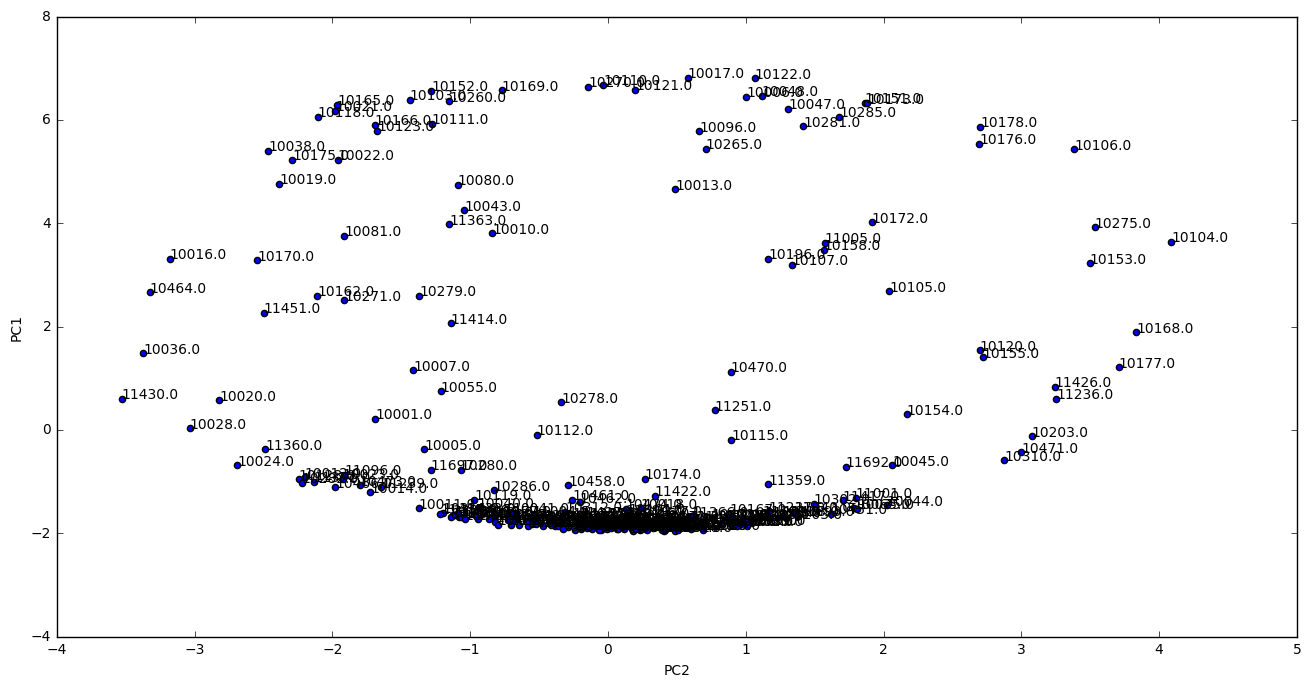

In [141]:
ax = existing_df_2d.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, country in enumerate(normed.index):
    ax.annotate(
        country, 
        (existing_df_2d.iloc[i].PC2, existing_df_2d.iloc[i].PC1)
    )

In [197]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit(normed)
existing_df_2d['cluster'] = pd.Series(clusters.labels_, index=existing_df_2d.index)
centroids = clusters.cluster_centers_

In [242]:
existing_df_2d.head(1)

,PC1,PC2,cluster
zip,,,
10001.0,0.21157,-1.689967,0


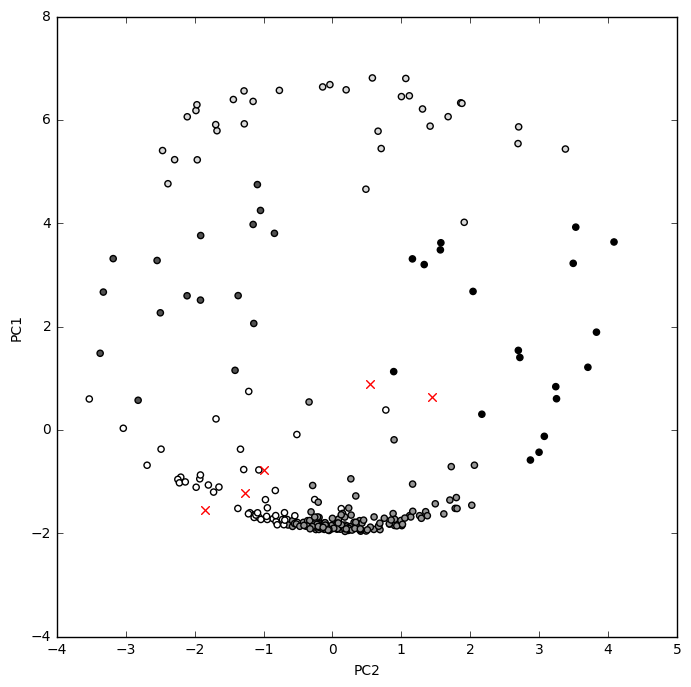

In [198]:
existing_df_2d.plot(
        kind='scatter',
        x='PC2',y='PC1',
        c=existing_df_2d.cluster.astype(np.float), 
        figsize=(8,8))

for x in centroids:
    pl.plot(centroids[:,0], centroids[:,1], 'rx')

### 4. Use another clustering algorithm (of your choice)

### 5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters

In [230]:
shapes = gp.read_file(shapefile)

In [231]:
shapes.rename(columns = {'postalCode': 'zip'}, inplace=True)
shapes['zip'] = pd.to_numeric(shapes['zip'], errors = 'coerce')
shapes = shapes.set_index('zip')

In [232]:
shapes.head(2)

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry
zip,,,,,,,,,,,
11372,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...
11004,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...


In [243]:
#pd.merge(normed, shapes, left_index=True, right_index=True, how='left')
norm_shapes = pd.merge(normed, shapes, left_index='true', right_index='true', how='inner')
norm_shapes_clusters = pd.merge(norm_shapes, existing_df_2d, left_index='true', right_index='true', how='inner')
norm_shapes_clusters.columns

Index([           1994.0,            1995.0,            1996.0,
                  1997.0,            1998.0,            1999.0,
                  2000.0,            2001.0,            2002.0,
                  2003.0,            2004.0,            2005.0,
                  2006.0,            2007.0,            2008.0,
                  2009.0,            2010.0,            2011.0,
                  2012.0,            2013.0,            2014.0,
                  u'@id', u'BLDGpostalCode',       u'CTY_FIPS',
             u'OBJECTID',        u'PO_NAME',          u'STATE',
              u'ST_FIPS',     u'Shape_Area',     u'Shape_Leng',
              u'borough',       u'geometry',            u'PC1',
                  u'PC2',        u'cluster'],
      dtype='object', name=u'year')

In [255]:
geo_df = GeoDataFrame(norm_shapes_clusters, geometry=norm_shapes_clusters['geometry'])

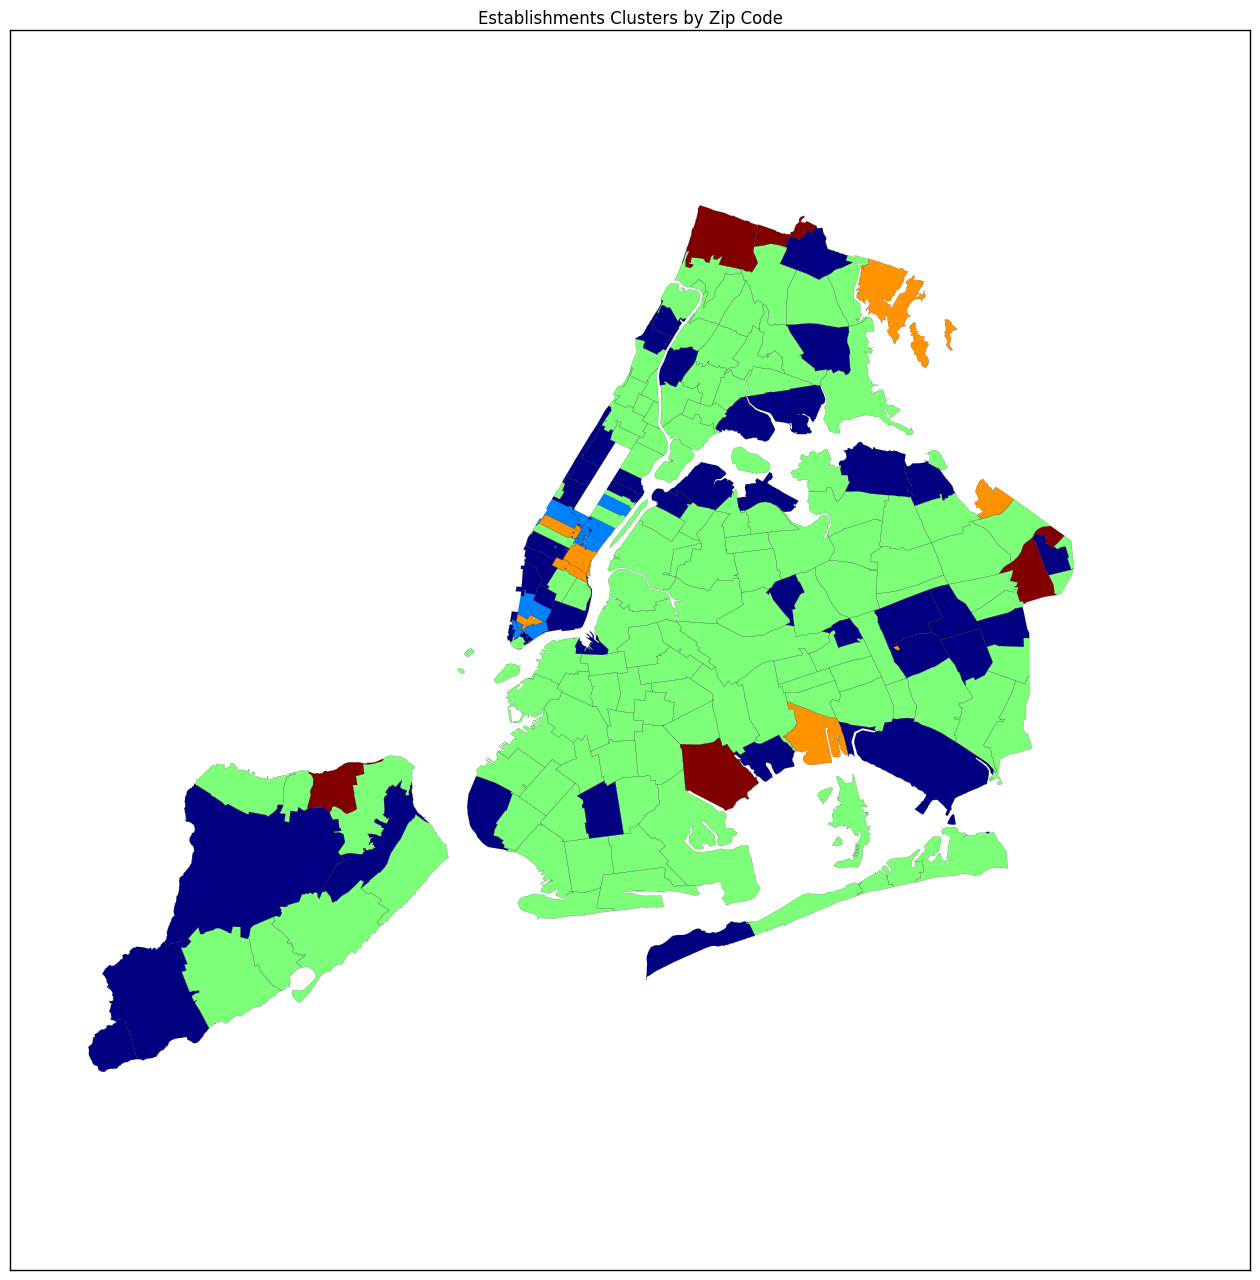

In [260]:
f, ax = plt.subplots(figsize=(16,16))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
geo_df.plot(column='cluster',alpha=1,linewidth=0.1,ax=ax)
plt.title("Establishments Clusters by Zip Code")
plt.legend()

And if you use hierarchical clustering and make a dandrogram it may look like this`

In [ ]:
from PIL import Image
Image.open("dandrogram.png")